# **Install**

In [ ]:
!pip install numpy==1.26.0
!pip install pandas==2.2.1
!pip install seaborn==0.13.2
!pip install matplotlib==3.8.3
!pip install scikit-learn==1.4.1.post1

# **Import**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Used Functions**

In [2]:
#Write here your function with comments

# **Data**

### **Data Read**

In [3]:
data=pd.read_csv("ApartmentRentPrediction.csv")

### **Data Header**

In [4]:
data.head(5)

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2.0,USD,No,Thumbnail,...,"$1,194",Monthly,800,NaN,Cary,NC,35.7585,-78.7783,RentDigs.com,1568755960
1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1.0,USD,No,Thumbnail,...,"$1,370",Monthly,795,640 West Wilson St,Madison,WI,43.0724,-89.4003,RentLingo,1577015508
2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1.0,USD,No,Thumbnail,...,"$1,009",Monthly,560,2777 SW Archer Road,Gainesville,FL,29.6533,-82.3656,RentLingo,1577358921
3,5668632604,housing/rent/apartment,One BR 534-542 Park Avenue,"This unit is located at 534-542 Park Avenue, O...",NaN,1.0,1.0,USD,No,Thumbnail,...,$695,Monthly,600,534-542 Park Ave,Omaha,NE,41.2562,-96.0404,RentLingo,1577359849
4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",NaN,3.0,3.0,USD,No,Thumbnail,...,"$3,695",Monthly,1600,2216 S Palm Grove Avenue,Los Angeles,CA,34.0372,-118.2972,RentLingo,1577360159


### **Data Describe**

In [5]:
data.describe()

,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,9.000000e+03,8970.000000,8993.000000,9000.000000,9000.000000,8993.00000,8993.000000,9.000000e+03
mean,5.623668e+09,1.380769,1.744023,1487.286222,947.138667,37.67689,-94.778612,1.574906e+09
std,7.007402e+07,0.616171,0.942446,1088.561190,668.806214,5.51527,15.769232,3.755142e+06
min,5.508654e+09,1.000000,0.000000,200.000000,106.000000,21.31550,-158.022100,1.568744e+09
25%,5.509250e+09,1.000000,1.000000,950.000000,650.000000,33.66200,-101.858700,1.568781e+09
50%,5.668610e+09,1.000000,2.000000,1275.000000,802.000000,38.75550,-93.707700,1.577358e+09
75%,5.668626e+09,2.000000,2.000000,1695.000000,1100.000000,41.34980,-82.446800,1.577359e+09
max,5.668663e+09,8.500000,9.000000,52500.000000,40000.000000,61.59400,-70.191600,1.577362e+09


### **Data Info**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             9000 non-null   int64  
 1   category       9000 non-null   object 
 2   title          9000 non-null   object 
 3   body           9000 non-null   object 
 4   amenities      5815 non-null   object 
 5   bathrooms      8970 non-null   float64
 6   bedrooms       8993 non-null   float64
 7   currency       9000 non-null   object 
 8   fee            9000 non-null   object 
 9   has_photo      9000 non-null   object 
 10  pets_allowed   5249 non-null   object 
 11  price          9000 non-null   int64  
 12  price_display  9000 non-null   object 
 13  price_type     9000 non-null   object 
 14  square_feet    9000 non-null   int64  
 15  address        6029 non-null   object 
 16  cityname       8934 non-null   object 
 17  state          8934 non-null   object 
 18  latitude

### **Data Nulls**

In [7]:
data.isna().sum()

id                  0
category            0
title               0
body                0
amenities        3185
bathrooms          30
bedrooms            7
currency            0
fee                 0
has_photo           0
pets_allowed     3751
price               0
price_display       0
price_type          0
square_feet         0
address          2971
cityname           66
state              66
latitude            7
longitude           7
source              0
time                0
dtype: int64

### **Datatype Check**

In [8]:
#Convert Bathrooms to int
#Convert Bedrooms to int
#Convert Has_Photo to category
#Convert State to int
#Convert Source to int
#Convert Time to int
#Convert Source to int

In [9]:
DataCheck = data.copy()

In [10]:
#DataCheck["bathrooms"] = DataCheck["bathrooms"].astype("int")

In [11]:
#DataCheck["bedrooms"] = DataCheck["bedrooms"].astype("int")

In [12]:
DataCheck["has_photo"] = DataCheck["has_photo"].astype("category")

In [13]:
DataCheck["state"] = DataCheck["state"].astype("category")

In [14]:
DataCheck["source"] = DataCheck["source"].astype("category")

In [15]:
DataCheck["time"] = pd.to_datetime(DataCheck["time"])

In [16]:
DataCheck["cityname"]=DataCheck["cityname"].astype("category")

In [17]:
DataCheck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             9000 non-null   int64         
 1   category       9000 non-null   object        
 2   title          9000 non-null   object        
 3   body           9000 non-null   object        
 4   amenities      5815 non-null   object        
 5   bathrooms      8970 non-null   float64       
 6   bedrooms       8993 non-null   float64       
 7   currency       9000 non-null   object        
 8   fee            9000 non-null   object        
 9   has_photo      9000 non-null   category      
 10  pets_allowed   5249 non-null   object        
 11  price          9000 non-null   int64         
 12  price_display  9000 non-null   object        
 13  price_type     9000 non-null   object        
 14  square_feet    9000 non-null   int64         
 15  address        6029 n

### **Needed Columns**

In [18]:
#Remove ID Column
#Remove Category Column
#Remove Title Column
#Remove Body Column
#Remove Currency Column
#Remove Fee Column
#Remove Price Display Column
#Remove Price Type Column
#Remove Time Column

In [19]:
#Remove ID Column
#Not useful in data
DataCheck = DataCheck.drop('id', axis=1)

In [20]:
#Remove Category Column
#Not useful in data due to 8997 "housing/rent/apartment" repetation
print(DataCheck['category'].value_counts())
DataCheck = DataCheck.drop('category', axis=1)

category
housing/rent/apartment     8997
housing/rent/short_term       2
housing/rent/home             1
Name: count, dtype: int64


In [21]:
#Remove Title Column
#Not useful in data
DataCheck = DataCheck.drop('title', axis=1)

In [22]:
#Remove Body Column
#Not useful in data
DataCheck = DataCheck.drop('body', axis=1)

In [23]:
#Remove address Column
#inconsistent data that have 3000 null rows
DataCheck = DataCheck.drop('address', axis=1)

In [24]:
#Remove Currency Column
#Not useful in data due to no unique values
print(DataCheck['currency'].value_counts())
DataCheck = DataCheck.drop('currency', axis=1)

currency
USD    9000
Name: count, dtype: int64


In [25]:
#Remove Fee Column
#Not useful in data due to no unique values
print(DataCheck['fee'].value_counts())
DataCheck = DataCheck.drop('fee', axis=1)

fee
No    9000
Name: count, dtype: int64


In [26]:
#Remove Price Display Column
#Not useful in data due to repition of price column
DataCheck['price_display'] = pd.to_numeric(DataCheck['price_display'].str.replace('$', '').str.replace(',', '').str.replace('Weekly', '').str.replace('Monthly|', ''))
comparison = DataCheck['price_display'] == DataCheck['price']
print(comparison.value_counts())
DataCheck = DataCheck.drop('price_display', axis=1)

True    9000
Name: count, dtype: int64


In [27]:
#Remove Price Type Column
#Not useful in data due to 8998 "Monthly" repetation
print(DataCheck['price_type'].value_counts())
DataCheck = DataCheck.drop('price_type', axis=1)

price_type
Monthly           8998
Weekly               1
Monthly|Weekly       1
Name: count, dtype: int64


In [28]:
#Remove Time Column
#Not useful in data due to 9000 "1970-01-01" date repetation
DataCheck = DataCheck.drop('time', axis=1)

In [29]:
#Check Data After Uneeded Columns Removal
DataCheck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   amenities     5815 non-null   object  
 1   bathrooms     8970 non-null   float64 
 2   bedrooms      8993 non-null   float64 
 3   has_photo     9000 non-null   category
 4   pets_allowed  5249 non-null   object  
 5   price         9000 non-null   int64   
 6   square_feet   9000 non-null   int64   
 7   cityname      8934 non-null   category
 8   state         8934 non-null   category
 9   latitude      8993 non-null   float64 
 10  longitude     8993 non-null   float64 
 11  source        9000 non-null   category
dtypes: category(4), float64(4), int64(2), object(2)
memory usage: 653.5+ KB


### **Fill Nulls**

In [30]:
# Data to work on
null_data=DataCheck.copy()

In [31]:
# Removing the null rows of cityname and latitude
null_data=null_data.dropna(axis=0,subset=["cityname","latitude","bathrooms","bedrooms"])

In [32]:
# Filling nulls of pets_allowed coloumn to no
null_data["pets_allowed"]=null_data["pets_allowed"].fillna("No")
null_data["pets_allowed"]=null_data["pets_allowed"].astype("category")

In [33]:
null_data["pets_allowed"].value_counts()

pets_allowed
Cats,Dogs    4651
No           3705
Cats          429
Dogs          113
Name: count, dtype: int64

In [34]:
null_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8898 entries, 0 to 8999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   amenities     5784 non-null   object  
 1   bathrooms     8898 non-null   float64 
 2   bedrooms      8898 non-null   float64 
 3   has_photo     8898 non-null   category
 4   pets_allowed  8898 non-null   category
 5   price         8898 non-null   int64   
 6   square_feet   8898 non-null   int64   
 7   cityname      8898 non-null   category
 8   state         8898 non-null   category
 9   latitude      8898 non-null   float64 
 10  longitude     8898 non-null   float64 
 11  source        8898 non-null   category
dtypes: category(5), float64(4), int64(2), object(1)
memory usage: 655.4+ KB


In [58]:
null_data.isna().sum()

amenities       3114
bathrooms          0
bedrooms           0
has_photo          0
pets_allowed       0
price              0
square_feet        0
cityname           0
state              0
latitude           0
longitude          0
source             0
dtype: int64

In [35]:
no_nulls_in_amenities = null_data.dropna(subset =["amenities"],axis =0)
#test["amenities"] = test["amenities"].str.split(",")
clone=no_nulls_in_amenities.copy()
no_nulls_in_amenities = no_nulls_in_amenities["amenities"].str.split(",")
no_nulls_in_amenities=no_nulls_in_amenities.reset_index()


In [36]:

li=[]
for x in range(len(no_nulls_in_amenities)) :
    li+=no_nulls_in_amenities.iloc[x]["amenities"]

In [37]:
li

['Clubhouse',
 'Fireplace',
 'Gym',
 'Patio/Deck',
 'Playground',
 'Pool',
 'Cable or Satellite',
 'Dishwasher',
 'Elevator',
 'Garbage Disposal',
 'Internet Access',
 'Parking',
 'Patio/Deck',
 'Refrigerator',
 'Storage',
 'Basketball',
 'Cable or Satellite',
 'Dishwasher',
 'Internet Access',
 'Patio/Deck',
 'Refrigerator',
 'Tennis',
 'Gym',
 'Pool',
 'Cable or Satellite',
 'Dishwasher',
 'Elevator',
 'Internet Access',
 'Parking',
 'Patio/Deck',
 'Playground',
 'Refrigerator',
 'Storage',
 'Wood Floors',
 'Dishwasher',
 'Parking',
 'Pool',
 'Refrigerator',
 'Gated',
 'Pool',
 'TV',
 'Dishwasher',
 'Internet Access',
 'Parking',
 'Pool',
 'Refrigerator',
 'AC',
 'Clubhouse',
 'Parking',
 'Playground',
 'Pool',
 'Dishwasher',
 'Parking',
 'Patio/Deck',
 'Refrigerator',
 'Parking',
 'Parking',
 'Patio/Deck',
 'Pool',
 'Tennis',
 'Parking',
 'Refrigerator',
 'Cable or Satellite',
 'Dishwasher',
 'Garbage Disposal',
 'Internet Access',
 'Parking',
 'Patio/Deck',
 'Refrigerator',
 'Parki

In [38]:
li=set(li)

In [39]:
li

{'AC',
 'Alarm',
 'Basketball',
 'Cable or Satellite',
 'Clubhouse',
 'Dishwasher',
 'Doorman',
 'Elevator',
 'Fireplace',
 'Garbage Disposal',
 'Gated',
 'Golf',
 'Gym',
 'Hot Tub',
 'Internet Access',
 'Luxury',
 'Parking',
 'Patio/Deck',
 'Playground',
 'Pool',
 'Refrigerator',
 'Storage',
 'TV',
 'Tennis',
 'View',
 'Washer Dryer',
 'Wood Floors'}

In [40]:
clone=clone.reset_index()

In [41]:
for c in li :
    clone[c]=0
    clone[c]=clone[c].astype("int")

In [42]:
clone

,index,amenities,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,...,Fireplace,Pool,Hot Tub,Golf,Basketball,Parking,Internet Access,Doorman,View,Tennis
0,0,"Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2.0,Thumbnail,"Cats,Dogs",1194,800,Cary,NC,...,0,0,0,0,0,0,0,0,0,0
1,1,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1.0,Thumbnail,"Cats,Dogs",1370,795,Madison,WI,...,0,0,0,0,0,0,0,0,0,0
2,2,"Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1.0,Thumbnail,"Cats,Dogs",1009,560,Gainesville,FL,...,0,0,0,0,0,0,0,0,0,0
3,6,"Gym,Pool",1.0,2.0,Yes,No,2470,1079,Lynnwood,WA,...,0,0,0,0,0,0,0,0,0,0
4,9,"Cable or Satellite,Dishwasher,Elevator,Interne...",1.0,2.0,Thumbnail,No,1225,995,Forest Lake,MN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5779,8992,Patio/Deck,1.0,1.0,Thumbnail,Cats,925,765,Houston,TX,...,0,0,0,0,0,0,0,0,0,0
5780,8994,"Clubhouse,Gym,Parking,Pool,Storage",2.0,2.0,Yes,No,1915,932,Maple Valley,WA,...,0,0,0,0,0,0,0,0,0,0
5781,8995,"Clubhouse,Gym,Patio/Deck,Pool",1.0,2.0,Thumbnail,No,1158,875,New London,CT,...,0,0,0,0,0,0,0,0,0,0
5782,8997,"Parking,Storage",1.0,2.0,Thumbnail,"Cats,Dogs",424,844,Fond Du Lac,WI,...,0,0,0,0,0,0,0,0,0,0


In [43]:



for new in range(len(clone)) :
    for col in li :
        if col in no_nulls_in_amenities.iloc[new]["amenities"] :
            clone.at[new,col]=1
            

In [44]:
clone["TV"].value_counts()

TV
0    5595
1     189
Name: count, dtype: int64

In [45]:
clone

,index,amenities,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,...,Fireplace,Pool,Hot Tub,Golf,Basketball,Parking,Internet Access,Doorman,View,Tennis
0,0,"Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2.0,Thumbnail,"Cats,Dogs",1194,800,Cary,NC,...,1,1,0,0,0,0,0,0,0,0
1,1,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1.0,Thumbnail,"Cats,Dogs",1370,795,Madison,WI,...,0,0,0,0,0,1,1,0,0,0
2,2,"Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1.0,Thumbnail,"Cats,Dogs",1009,560,Gainesville,FL,...,0,0,0,0,1,0,1,0,0,1
3,6,"Gym,Pool",1.0,2.0,Yes,No,2470,1079,Lynnwood,WA,...,0,1,0,0,0,0,0,0,0,0
4,9,"Cable or Satellite,Dishwasher,Elevator,Interne...",1.0,2.0,Thumbnail,No,1225,995,Forest Lake,MN,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5779,8992,Patio/Deck,1.0,1.0,Thumbnail,Cats,925,765,Houston,TX,...,0,0,0,0,0,0,0,0,0,0
5780,8994,"Clubhouse,Gym,Parking,Pool,Storage",2.0,2.0,Yes,No,1915,932,Maple Valley,WA,...,0,1,0,0,0,1,0,0,0,0
5781,8995,"Clubhouse,Gym,Patio/Deck,Pool",1.0,2.0,Thumbnail,No,1158,875,New London,CT,...,0,1,0,0,0,0,0,0,0,0
5782,8997,"Parking,Storage",1.0,2.0,Thumbnail,"Cats,Dogs",424,844,Fond Du Lac,WI,...,0,0,0,0,0,1,0,0,0,0


In [46]:
clone=clone.drop("amenities",axis=1)
clone["cityname"]=clone["cityname"].astype("category")

In [47]:
clone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5784 entries, 0 to 5783
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   index               5784 non-null   int64   
 1   bathrooms           5784 non-null   float64 
 2   bedrooms            5784 non-null   float64 
 3   has_photo           5784 non-null   category
 4   pets_allowed        5784 non-null   category
 5   price               5784 non-null   int64   
 6   square_feet         5784 non-null   int64   
 7   cityname            5784 non-null   category
 8   state               5784 non-null   category
 9   latitude            5784 non-null   float64 
 10  longitude           5784 non-null   float64 
 11  source              5784 non-null   category
 12  Washer Dryer        5784 non-null   int32   
 13  Patio/Deck          5784 non-null   int32   
 14  Elevator            5784 non-null   int32   
 15  Gated               5784 non-null   in

In [48]:
for col in clone.columns:
    if clone[col].dtype=="category" :
        clone[col]=clone[col].cat.codes

In [49]:
clone

,index,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,latitude,...,Fireplace,Pool,Hot Tub,Golf,Basketball,Parking,Internet Access,Doorman,View,Tennis
0,0,2.5,2.0,1,1,1194,800,221,26,35.7585,...,1,1,0,0,0,0,0,0,0,0
1,1,1.0,1.0,1,1,1370,795,763,47,43.0724,...,0,0,0,0,0,1,1,0,0,0
2,2,1.0,1.0,1,1,1009,560,481,9,29.6533,...,0,0,0,0,1,0,1,0,0,1
3,6,1.0,2.0,2,3,2470,1079,759,46,47.8616,...,0,1,0,0,0,0,0,0,0,0
4,9,1.0,2.0,1,3,1225,995,453,22,45.2764,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5779,8992,1.0,1.0,1,0,925,765,599,42,29.8224,...,0,0,0,0,0,0,0,0,0,0
5780,8994,2.0,2.0,2,3,1915,932,783,46,47.3949,...,0,1,0,0,0,1,0,0,0,0
5781,8995,1.0,2.0,1,3,1158,875,921,6,41.3498,...,0,1,0,0,0,0,0,0,0,0
5782,8997,1.0,2.0,1,1,424,844,450,47,43.7815,...,0,0,0,0,0,1,0,0,0,0


In [50]:
cor = clone.corr()

<Axes: >

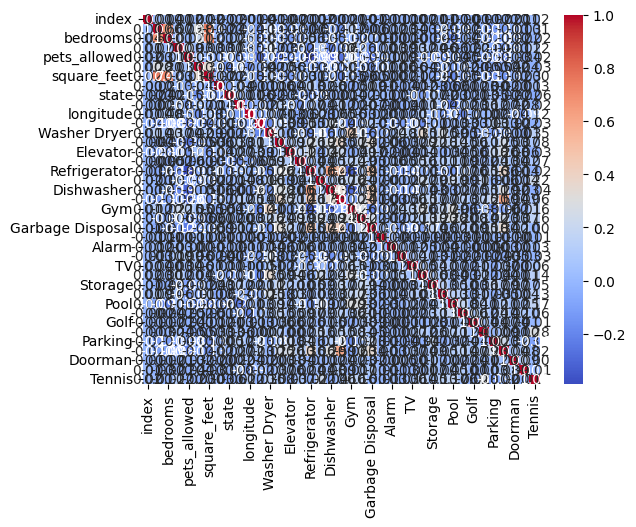

In [51]:
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt=".2f")

In [52]:
cor

,index,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,cityname,state,latitude,...,Fireplace,Pool,Hot Tub,Golf,Basketball,Parking,Internet Access,Doorman,View,Tennis
index,1.000000,0.014502,0.035487,0.011802,0.017068,0.002268,0.020278,0.004996,-0.015790,-0.004215,...,0.005367,0.002557,-0.004296,-0.014094,-0.007204,-0.020634,-0.015356,-0.009680,0.013398,0.022952
bathrooms,0.014502,1.000000,0.655219,0.070987,0.033015,0.281399,0.741539,-0.019932,-0.035933,-0.023638,...,0.094346,-0.091064,-0.019054,-0.006777,-0.026394,-0.124490,-0.102841,-0.011477,-0.028510,0.011103
bedrooms,0.035487,0.655219,1.000000,0.007276,-0.006559,0.207887,0.720128,0.005041,-0.023582,0.057662,...,0.043494,-0.206876,-0.042722,-0.021149,-0.018340,-0.100143,-0.090013,-0.022883,-0.015592,-0.023188
has_photo,0.011802,0.070987,0.007276,1.000000,0.094281,0.026642,0.030457,0.029091,0.012024,0.079280,...,0.061760,0.061837,-0.019150,-0.017336,0.040107,-0.044987,-0.079791,-0.005415,-0.021206,0.119948
pets_allowed,0.017068,0.033015,-0.006559,0.094281,1.000000,0.049392,-0.010098,-0.066849,0.045363,-0.088000,...,-0.103546,-0.037168,-0.047367,-0.039829,-0.052586,-0.076881,-0.205576,-0.027989,-0.035341,-0.019897
price,0.002268,0.281399,0.207887,0.026642,0.049392,1.000000,0.343674,0.035203,-0.156936,0.068983,...,-0.007278,-0.075216,0.018436,0.001387,-0.045383,-0.046988,-0.040549,0.016531,0.037329,-0.034827
square_feet,0.020278,0.741539,0.720128,0.030457,-0.010098,0.343674,1.000000,-0.019136,-0.015588,-0.009482,...,0.102247,-0.163585,-0.047777,-0.012177,-0.034047,-0.128015,-0.130939,-0.021984,-0.025260,0.003176
cityname,0.004996,-0.019932,0.005041,0.029091,-0.066849,0.035203,-0.019136,1.000000,-0.102749,0.039520,...,-0.060895,-0.063043,0.007890,0.022437,0.033275,0.002267,0.024707,-0.004481,-0.010612,0.034346
state,-0.015790,-0.035933,-0.023582,0.012024,0.045363,-0.156936,-0.015588,-0.102749,1.000000,0.007448,...,0.020283,0.033342,-0.017472,0.007086,0.025129,0.052992,-0.016437,-0.021232,-0.019880,-0.062363
latitude,-0.004215,-0.023638,0.057662,0.079280,-0.088000,0.068983,-0.009482,0.039520,0.007448,1.000000,...,0.037117,-0.218633,0.019180,0.033024,0.060601,0.118243,0.065060,0.023134,0.077584,-0.018442


In [53]:
cor["price"]<=-0.3

index                 False
bathrooms             False
bedrooms              False
has_photo             False
pets_allowed          False
price                 False
square_feet           False
cityname              False
state                 False
latitude              False
longitude             False
source                False
Washer Dryer          False
Patio/Deck            False
Elevator              False
Gated                 False
Refrigerator          False
Playground            False
Dishwasher            False
Cable or Satellite    False
Gym                   False
Clubhouse             False
Garbage Disposal      False
Luxury                False
Alarm                 False
Wood Floors           False
TV                    False
AC                    False
Storage               False
Fireplace             False
Pool                  False
Hot Tub               False
Golf                  False
Basketball            False
Parking               False
Internet Access     

In [54]:
sorted_correlation = cor['price'].abs().sort_values(ascending=False)

In [55]:
sorted_correlation

price                 1.000000
square_feet           0.343674
bathrooms             0.281399
bedrooms              0.207887
state                 0.156936
longitude             0.134528
Garbage Disposal      0.098558
Playground            0.087346
Pool                  0.075216
Cable or Satellite    0.074902
latitude              0.068983
Wood Floors           0.064317
Elevator              0.062136
Clubhouse             0.056125
TV                    0.055719
pets_allowed          0.049392
Patio/Deck            0.047128
Parking               0.046988
Gym                   0.046242
Dishwasher            0.045479
Basketball            0.045383
Internet Access       0.040549
AC                    0.038283
View                  0.037329
source                0.036493
cityname              0.035203
Tennis                0.034827
Refrigerator          0.029527
has_photo             0.026642
Washer Dryer          0.024633
Hot Tub               0.018436
Storage               0.018383
Doorman 